# Main



Now some text explaining stuff

## General requirements

In [1]:
from matplotlib.pylab import *
from numpy import *
%matplotlib inline

In [2]:
from Nanorods.sub.subs import *
from matlab.function_EMCCD_CMOS_calib import *

In [3]:
visualization?

In [4]:
#from Nanorods.sub.subs import *\    
def visualization(imA,pos=None,widthr=5,heightr=5,contrastd=1.0,contrastu=2.5,figname="",color='red',figsize = (7,4.5)):
    fig = figure(figname,figsize = figsize)
    ax = fig.add_subplot(111)
    imt = imA*1.0; me = mean(imt.flatten()); sd = std(imt.flatten());
    imt[imt>me+contrastu*sd] = me+contrastu*sd; imt[imt<me-contrastd*sd] = me-contrastd*sd;
    ax.imshow(imt,cmap='gray')
    if pos is None:
        pass
    else:
        for a_x, a_y in pos:
            ax.add_patch(Rectangle(xy=(a_x-widthr/2, a_y-heightr/2) ,width=widthr, height=heightr, linewidth=1.5, color=color,alpha=0.95, fill=False))
    axis('off')
    subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    margins(0,0)
    gca().xaxis.set_major_locator(NullLocator())
    gca().yaxis.set_major_locator(NullLocator())

    return((fig,ax))


In [4]:
import PIL
import PIL.ExifTags as Exiftags

In [5]:
fromsubs = True
if fromsubs:
    from matlab.tifmethods import readBigTifFile
else:
    def readBigTifFile(fname):
        img = PIL.Image.open(fname)
        imf = img.tag_v2
        keys = []
        for key in imf.keys():
            keys.append(key)

        width, height = imf[keys[0]],imf[keys[1]]
        nframes = int(imf[270].split()[1][7:])
        size = nframes*width*height

        offset = imf[273][0]
        print(offset)
        with open(fname,"rb") as file:
            file.seek(offset)
            temp = fromfile(file,dtype=">u2")

        temp = temp[:size].reshape((nframes,height,width))
        return(temp)

In [7]:
fname = "C:\\Users\ludwig\Documents\Python data\cell1_BeRST.tif"
fname = '/mnt/data/Anastasia/sample folder with NR data/image files/'
movie = readBigTifFile(fname)
movie = movie.sum(axis=0)

IsADirectoryError: [Errno 21] Is a directory: '/mnt/data/Anastasia/sample folder with NR data/'

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19f4b0fc4e0>)

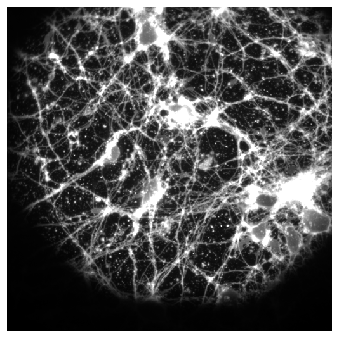

In [11]:
visualization(movie)

In [12]:
folder = r"C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files"
fname = r"\wave\cell1_1.tif"
movie = readBigTifFile(folder+fname)
movie = movie.sum(axis=0) # sum(movie,axis=0)

6517240


(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19f4b19ecf8>)

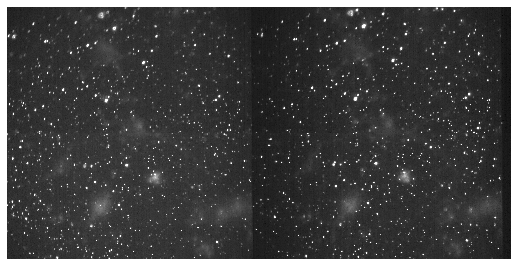

In [13]:
visualization(movie)

##     Mask generation and three fields alignment.

### cMOS camera fields alignment
### EMCCD mask generation
### Transposition of mask two CMOS images


In [14]:
import os
#import warning
import numpy as np
from scipy.stats import  linregress
from matlab.tifmethods import readtifImage
import csv
from matlab.CenterROIs import centerROIs

def ReadCSV(fname):
    rows = []
    with open(fname) as csvf:
        csvr = csv.reader(csvf, delimiter = ',')
        for row in csvr:
            try:
                rows.append(np.array(row,dtype=float).tolist())
            except:
                pass
    return(np.array(rows))
    
def EMCCD_CMOS_calib(folder = './',csv = True, ROIsize=9):

    #Extracting images and csv files
    files_tif = []
    files_csv = []
    # ~ filenames = []
    for file in os.listdir(folder):
        if file.endswith('.tif'):
            files_tif.append(file)
            # ~ filenames.append(file.split('_')[0])
        elif file.endswith('.csv'):
            files_csv.append(file)
            
    
    # ~ filenames = list(set(filenames))
    # ~ filenames.sort()
    files_tif.sort()
    files_csv.sort()
    #files = {name: [] for name in filenames}
        
    # Let us subdivide files with name of the cell
    # ~ for file in files_tif:
        # ~ filename = file.split('_')[0]
        # ~ files[filename].append(file)
    
    files = files_tif
    filesCMOS = [file for file in files if file.find('CMOS')>=0]
    if len(filesCMOS) == 0:
        raise ValueError('Sorry, there are no files with CMOS in their name.')
    
    
    filesEMCCD = [file for file in files if file.find('EMCCD')>=0]
    if len(filesEMCCD)==0:
        raise ValueError('We stop, no files with EMCCD in their name, for '+name+'.')
    
    files = files_csv
    filesCMOScsv = [file for file in files if file.find('CMOS')>=0]
    if len(filesCMOS) == 0:
        raise ValueError('Sorry, there are no files with CMOS in their name.')
    
    
    filesEMCCDcsv = [file for file in files if file.find('EMCCD')>=0]
    if len(filesEMCCD)==0:
        raise ValueError('We stop, no files with EMCCD in their name, for '+name+'.')
    
    ptsC = []
    ptsE = []
    for i,names in enumerate(zip(filesCMOS,filesEMCCD)): #real traces
        fCMOS, fEMCCD = names
    
        # Change these lines to appropiate reading of tif files:
        CMOS = readtifImage(folder+fCMOS)
        EMCCD= readtifImage(folder+fEMCCD)
    
        CMOS = CMOS[:,:CMOS.shape[1]//2]
    
        if not csv:
            # Produce csv - pass it to subroutine    
            pass
        else:
            fCMOScsv, fEMCCDcsv =  (filesCMOScsv[i],filesEMCCDcsv[i])
            # Read positions of ROIS in csv files
            CMOS_pts = ReadCSV(folder+fCMOScsv)
            EMCCD_pts  = ReadCSV(folder+fEMCCDcsv)
               
            CMOS_pts=array(CMOS_pts[:,1:],dtype=int)
            EMCCD_pts=array(EMCCD_pts[:,1:], dtype=int)
            
        #CenterROIs function
        CMOS_pts_center=centerROIs(CMOS,CMOS_pts,ROIsize)
        EMCCD_pts_center=centerROIs(EMCCD,EMCCD_pts,ROIsize)
                    
        if i==0:
            ptsC = CMOS_pts_center
            ptsE = EMCCD_pts_center
        else:
            ptsC = row_stack((ptsC,CMOS_pts_center))
            ptsE = row_stack((ptsE,EMCCD_pts_center))
            
    Xc=ptsC[:,0]
    Yc=ptsC[:,1]
    Xe=ptsE[:,0]
    Ye=ptsE[:,1]

    fitobject = linregress(Xc,Xe)
    #slope, intercept, r_value, p_value, std_err
    ax, bx, _, _, _ = fitobject

    fitobject = linregress(Yc,Ye)
    #slope, intercept, r_value, p_value, std_err
    ay, by, _, _, _ = fitobject

    return(ax,ay,bx,by)

In [15]:
file_wave='\cell1_BeRST.tif'
f=3 #averaging factor for the mask

#EMCCD-CMOS calib results
ax, ay, bx, by = EMCCD_CMOS_calib(folder+"\EMCCD-CMOS calib\\");

In [16]:
print(ax, ay,bx, by)

0.7910246816347403 0.8152787153028243 74.96592913252289 -33.87204042892071


In [23]:
from matlab.tifmethods import *
info = readtifInfo(folder+file_wave)
NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
Nframes = int(NframesStr)
Stim=tile([-60, 0],Nframes//2);

movie = readBigTifFile(folder+file_wave)
movie_sum = movie.sum(axis=0)
SizeX,SizeY = movie_sum.shape



In [25]:
CorCoef_wave = zeros((SizeX, SizeY))
for x in range(SizeX):
    for y in range(SizeY):
        temp = corrcoef(movie[:,x,y],Stim)
        CorCoef_wave[x,y]=temp[1,0];



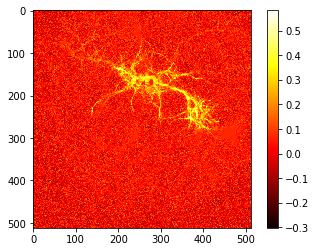

In [26]:
imshow(CorCoef_wave, cmap='hot')
colorbar()

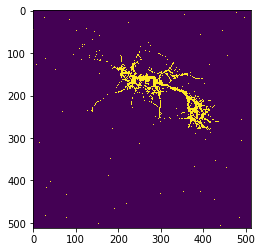

In [28]:
thld=mean(CorCoef_wave)+2.2*std(CorCoef_wave)
Mask_EMCCD=CorCoef_wave*1
Mask_EMCCD[Mask_EMCCD<thld]=0;
Mask_EMCCD[Mask_EMCCD>=thld]=1;
imshow(Mask_EMCCD);

In [ ]:
temp1=movavg (Mask_EMCCD,5,0);
temp2=movavg (temp1,5,1);
temp3=Mask_EMCCD;
temp3(temp2<=0.15)=nan;
temp3(temp3==0)=nan;

In [57]:
def movavgy (img, wind):
    sizeX, sizeY = img.shape
    imga=img*0
    wind2=wind//2
    for y in range(sizeY):
        for x in range(wind2,sizeX-wind2):
            imga[x,y]=nanmean(img[x-wind2:x+wind2+1,y])
    return imga
def movavgx (img, wind):
    return movavgy(img.transpose(), wind).transpose()


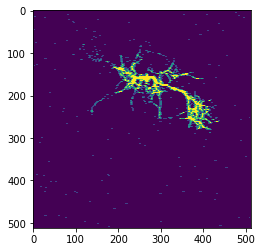

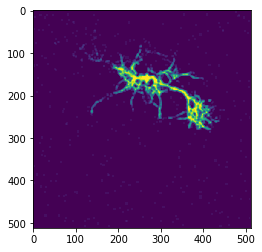

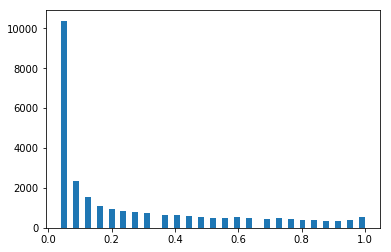

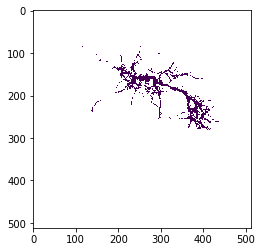

In [58]:
temp1=movavgx (Mask_EMCCD,5);
temp2=movavgy (temp1,5);
imshow(temp1)
figure()
imshow(temp2)
figure()
temp=temp2.flatten()
hist(temp[temp>0],51)
temp3=Mask_EMCCD*1;
temp3[temp2<=0.15]=nan;
temp3[temp3==0]=nan;
figure()
imshow(temp3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


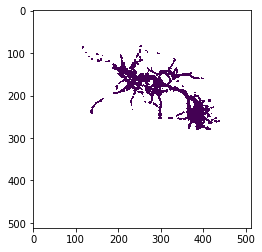

In [59]:
f=3
temp1=movavgx(temp3,f);
Mask_EMCCD_exp=movavgy (temp1,f);
imshow(Mask_EMCCD_exp)

(512, -10)

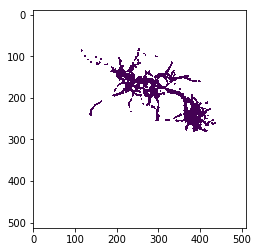

In [60]:
imshow(Mask_EMCCD_exp)
ylim(512,-10)

In [29]:
import cv2

In [71]:
def calib(Mask, ax, ay, bx, by):
    Mask_CMOS=zeros(Mask.shape);
    for Xc in range(Mask_CMOS.shape[1]):
        for Yc in range(Mask_CMOS.shape[0]):
            Xe=int(ax*Xc+bx);
            Ye=int(ay*Yc+by);
            if Xe>-1 and Xe<Mask.shape[1] and Ye>-1 and Ye<Mask.shape[0]:
                Mask_CMOS[Yc,Xc]=Mask[Ye, Xe];
    Mask_CMOS[isnan(Mask_CMOS)]=0
    
    #kernel=2
    #kernelm = cv2.UMat(ones((kernel,kernel),float32)/float(kernel)**2)
    #dilated = cv2.dilate(Mask_CMOS,kernel=kernelm)
    return Mask_CMOS #array(dilated.get())


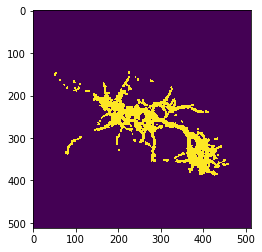

In [72]:
Mask_CMOS=calib(Mask_EMCCD_exp, ax, ay, bx, by)
imshow(Mask_CMOS)

##   Local maxima detection and ROI detection
### Local maxima detection
### Blinking coefficient and selection
### Neural-net?


In [73]:
dx, dy = 512,4

In [74]:
folder = r"C:\Users\ludwig\data\NR sample files\18_11_29_pd23_11_div6_WIS_NR-BeRST\image files"
fname = r"\wave\cell1_1.tif"
movie = readBigTifFile(folder+fname)
movie_sum = movie.sum(axis=0) # sum(movie,axis=0)


In [75]:
info = readtifInfo(folder+fname)
NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
Nframes = int(NframesStr)

In [81]:
TacqStr = [d for d in info[270].split('\n') if d.find('finterval')>=0][0].split('=')[-1]
Tacq = float(TacqStr)


In [80]:
# Generating stimulation trace
Stim=tile([0, 0, -60, -60],Nframes//4);

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19f4df53e48>)

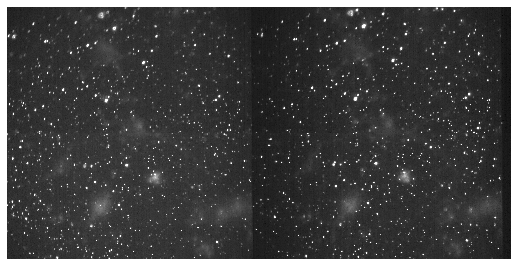

In [82]:
visualization(movie_sum)

In [90]:
kernel = 5
ROIsize=5
km = ones((kernel,kernel),float32)#/float(kernel)**2
J = zeros(Mask_CMOS.shape)
rs2 = kernel//2
mx,my = Mask_CMOS.shape

for x in range(0,mx-kernel):
    for y in range(0,my-kernel):
        temp = km*movie_sum[x:(x+kernel),y:(y+kernel)]
        J[x+rs2,y+rs2] = temp.max()

In [92]:
mx,my = Mask_CMOS.shape
pts = [] 
for x in range(2*ROIsize+1,mx-2*ROIsize):
    for y in range(2*ROIsize,my-2*ROIsize):
        if Mask_CMOS[x,y]>0 and J[x, y]==movie_sum[x, y]:
            pts.append([y, x])


pts = array(pts)

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19f4b686f28>)

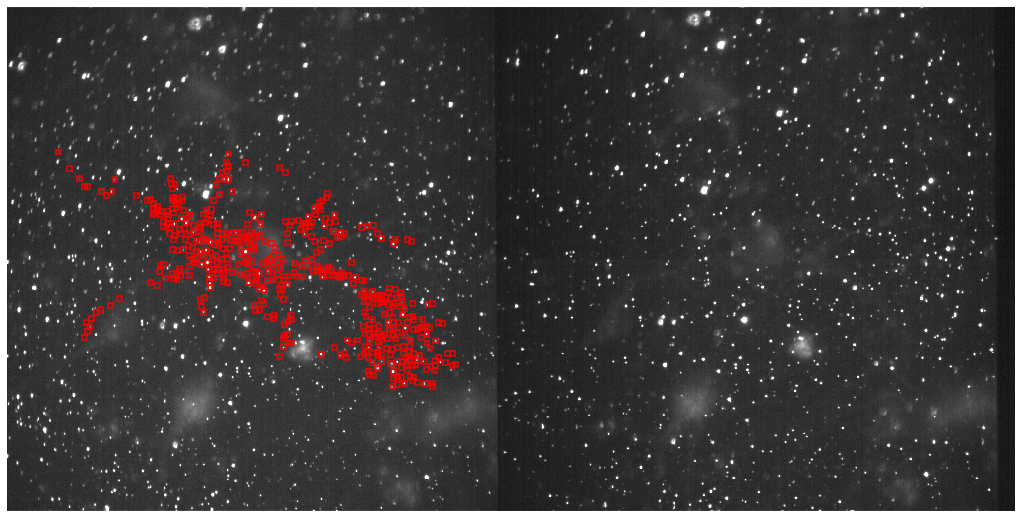

In [94]:
visualization(movie_sum,pts,figsize=(14,14))

In [95]:
x=pts[:,0]+dx
y=pts[:,1]+dy

In [96]:
sel = x+floor(ROIsize/2)<movie_sum.shape[1]
sel = sel*(y+floor(ROIsize/2)<movie_sum.shape[0])
sel = sel*(y-floor(ROIsize/2)>0)
x = x[sel]
y = y[sel]

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19f567fdbe0>)

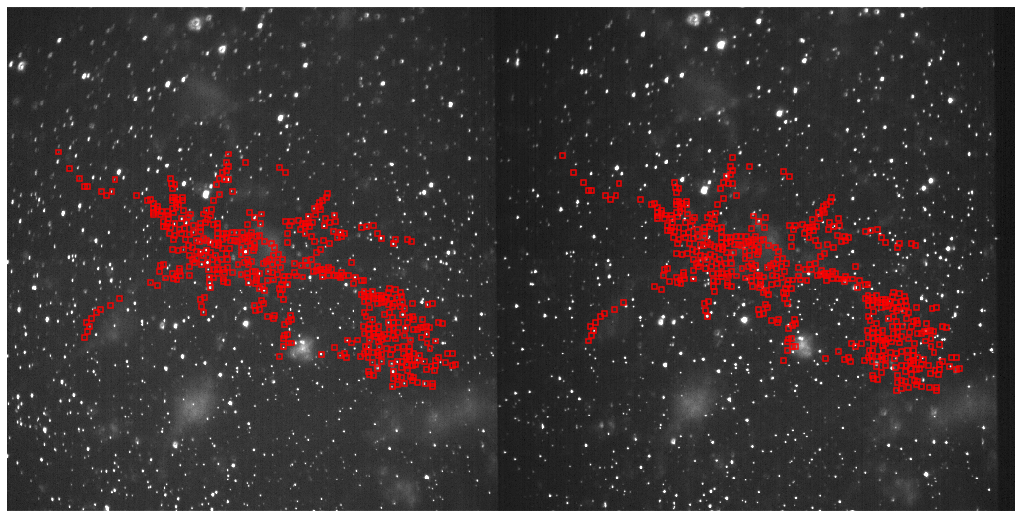

In [98]:
ptsr=column_stack((x,y))
ptsb=pts*1
pts_all=row_stack((ptsb,ptsr))
visualization(movie_sum,pts_all,figsize=(14,14))

##   Processing ROIs:
### Linearization of ROI
### Blinking substraction
### Stitching cycles
### Mobility



##    Extracting Signal
### FT score calculation
### Interval extraction



##   Bootstrap?

